# MBDoE Example: Reaction Kinetics

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

    

## Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize

## Define Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

The concenration in a **batch reactor** evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
def batch_rxn_model(theta, t, CA0, T):
    '''
    
    Predict batch reaction performance
    
    Arugments:
        t: time, [hour], scalar or Numpy array
        theta: fitted parameters: A1, A2, E1, E2
        CA0: initial concentration, [mol/L], scalar or numpy array
        T: temperature, [K], scalar or Numpy array
    Returns:
        CA, CB, CC: Concentrations at times t, [mol/L], three scalars or numpy arrays
    '''
    
    def kinetics(A, E, T):
        ''' Computes kinetics from Arrhenius equation
        Arguments:
            A: pre-exponential factor, [1 / hr]
            E: activation energy, [kJ / mol]
            T: temperature, [K]
        Returns:
            k: reaction rate coefficient, [1/hr] or [1/hr*L/mol]
        '''
        R = 8.31446261815324 # J / K / mole

        return A * np.exp(-E*1000/(R*T))

    # units: [1/hr]
    k1 = kinetics(theta[0], theta[2], T)

    # units: [1/hr]
    k2 = kinetics(theta[1], theta[3], T)

    # units: [mol / L]
    CA = CA0 * np.exp(-k1*t);
    CB = k1*CA0/(k2-k1) * (np.exp(-k1*t) - np.exp(-k2*t));
    CC = CA0 - CA - CB;

    return CA, CB, CC


Now let's test the code by running it.

In [3]:
theta_true = [85., 370., 7.5, 15]
time_exp = np.linspace(0,1,11) # hr
CA0_exp1 = 1.0 # mol/L
T_exp1 = 400 # K
CA_exp1, CB_exp1, CC_exp1 = batch_rxn_model(theta_true, time_exp, CA0_exp1, T_exp1)

## Generate Synthetic Experimental Dataset

Let's construct a dataset containing: 
* Batch experiment at $T=400$ K and $C_{AO}=1.0$ mol/L
* Batch experiment at $T=300$ K and $C_{AO}=3.0$ mol/L

We also simulated the first experiment. Let's simulate the second.

In [4]:
theta_true = [85., 370., 7.5, 15]
CA0_exp2 = 3.0 # mol/L
T_exp2 = 300 # K
CA_exp2, CB_exp2, CC_exp2 = batch_rxn_model(theta_true, time_exp, CA0_exp2, T_exp2)

Next let's add random normally distributed noise.

In [54]:
n_time = len(time_exp)

noise_std_dev = 0.05

CA_exp1 += noise_std_dev*np.random.normal(size=n_time)
CA_exp2 += noise_std_dev*np.random.normal(size=n_time)
CB_exp1 += noise_std_dev*np.random.normal(size=n_time)
CB_exp2 += noise_std_dev*np.random.normal(size=n_time)
CC_exp1 += noise_std_dev*np.random.normal(size=n_time)
CC_exp2 += noise_std_dev*np.random.normal(size=n_time)

Now we'll package these into a numpy array:

In [6]:
# Create empty array for experiment 1
exp1 = np.zeros((n_time,7))

# Assign 1 to column 0. This is the experiment number.
exp1[:,0] = 1

# Copy CA0 into column 1
exp1[:,1] = CA0_exp1

# Copy T into column 2 
exp1[:,2] = T_exp1

# Copy time data into column 3
exp1[:,3] = time_exp

# Copy concentration data into remaining columns
exp1[:,4] = CA_exp1
exp1[:,5] = CB_exp1
exp1[:,6] = CC_exp1

print(exp1)

[[ 1.00000000e+00  1.00000000e+00  4.00000000e+02  0.00000000e+00
   1.01593344e+00  4.00107806e-02  1.52647127e-02]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  1.00000000e-01
   3.49971528e-01  4.69600324e-01  1.48916063e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  2.00000000e-01
   1.52571925e-01  5.36085783e-01  2.35168796e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  3.00000000e-01
   7.39604589e-02  3.58795063e-01  4.52005512e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  4.00000000e-01
   6.99075763e-02  3.16452331e-01  6.49583690e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  5.00000000e-01
   2.25946415e-02  2.44993780e-01  8.03390123e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  6.00000000e-01
  -1.20006473e-01  1.97999487e-01  8.42609516e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  7.00000000e-01
  -2.22660735e-03  7.76324744e-02  8.41342684e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  8.00000000e-0

In [7]:
# Create empty array for experiment 2
exp2 = np.zeros((n_time,7))

# Assign 2 to column 0. This is the experiment number.
exp2[:,0] = 2

# Copy CA0 into column 1
exp2[:,1] = CA0_exp2

# Copy T into column 2 
exp2[:,2] = T_exp2

# Copy time data into column 3
exp2[:,3] = time_exp

# Copy concentration data into remaining columns
exp2[:,4] = CA_exp2
exp2[:,5] = CB_exp2
exp2[:,6] = CC_exp2

print(exp2)

[[ 2.00000000e+00  3.00000000e+00  3.00000000e+02  0.00000000e+00
   3.04199451e+00 -4.86245307e-02  3.31914335e-02]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  1.00000000e-01
   1.96665407e+00  9.19990362e-01  1.39533318e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  2.00000000e-01
   1.29826600e+00  1.59793051e+00  1.35993853e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  3.00000000e-01
   9.18700728e-01  1.90652044e+00  2.86959559e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  4.00000000e-01
   5.05820000e-01  1.88328811e+00  5.14664974e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  5.00000000e-01
   3.51562409e-01  1.84131368e+00  7.53348235e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  6.00000000e-01
   2.02479486e-01  1.95629438e+00  8.55484292e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  7.00000000e-01
   1.39963806e-01  1.90647132e+00  1.09082705e+00]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  8.00000000e-0

In [8]:
# Vertically stack data
exps = np.vstack((exp1,exp2))

# Create a dataframe with specific columns
# Pro Tip: Use 'temp' for temeprature instead of 'T'.
#   'T' can be confused with transpose.
df = pd.DataFrame(exps, columns=['exp', 'CA0','temp','time', 'CA','CB','CC'])

df.head()

,exp,CA0,temp,time,CA,CB,CC
0,1.0,1.0,400.0,0.0,1.015933,0.040011,0.015265
1,1.0,1.0,400.0,0.1,0.349972,0.469600,0.148916
2,1.0,1.0,400.0,0.2,0.152572,0.536086,0.235169
3,1.0,1.0,400.0,0.3,0.073960,0.358795,0.452006
4,1.0,1.0,400.0,0.4,0.069908,0.316452,0.649584


Finally, let's plot the data and the true model.

In [37]:
def plot_data_and_model(theta_, data1):
    '''
    Plot regression results

    Args:
        theta: model parameters
        data: Pandas data frame

    Returns:
        Nothing
    '''

    # loop over experiments
    for i in data1.exp.unique():

        ## Plot 1: Data Versus Prediction
        
        # delcare figure object
        fig, ax = plt.subplots(figsize=(12,10))
        # select the rows that correspond to the specific experiment number
        j = (data1.exp == i)

        # determine experiment conditions
        CA0_ = float(data1.CA0[j].mode())
        T_ = float(data1.temp[j].mode())
        
        # Plot dataset 1
        plt.plot(data1.time[j], data1.CA[j], marker='o',markersize=16,linestyle="",color="blue",label="$C_{A}$ Data")
        plt.plot(data1.time[j], data1.CB[j], marker='s',markersize=16,linestyle="",color="green",label="$C_{B}$ Data")
        plt.plot(data1.time[j], data1.CC[j], marker='^',markersize=16,linestyle="",color="red",label="$C_{C}$ Data")
        
        # determine time set
        t_plot = np.linspace(np.min(data1.time[j]),np.max(data1.time[j]),21)
        
        # Evaluate model
        CA_, CB_, CC_ = batch_rxn_model(theta_,t_plot,CA0_,T_)
        
        # Plot model predictions
        plt.plot(t_plot, CA_, linestyle="-",color="blue",label="$C_{A}$ Model")
        plt.plot(t_plot, CB_, linestyle="-.",color="green",label="$C_{B}$ Model")
        plt.plot(t_plot, CC_, linestyle="--",color="red",label="$C_{C}$ Model")

        # Add "extras" to the plot
        plt.xlabel("Time [hours]")
        plt.ylabel("Concentration [mol/L]")
        plt.title("Experiment "+str(round(i))+":  T="+str(T_)+" K,  CA0="+str(CA0_)+" mol/L")
        plt.legend()
        plt.grid()
        plt.show()

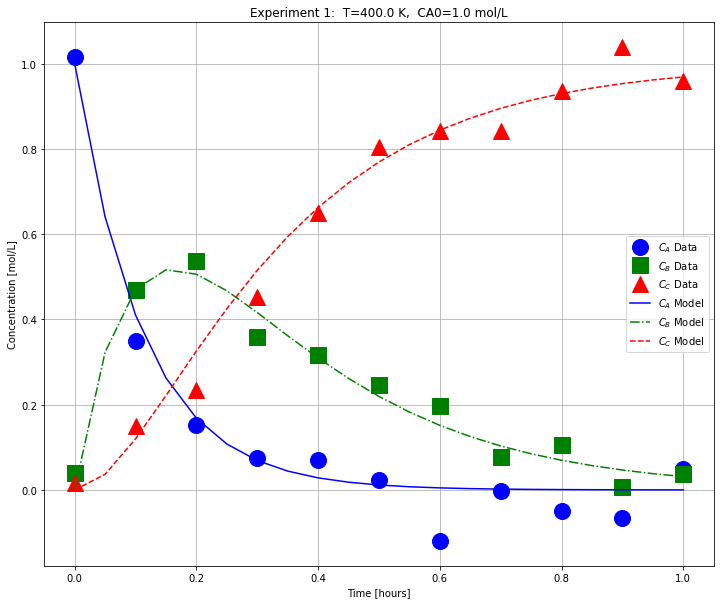

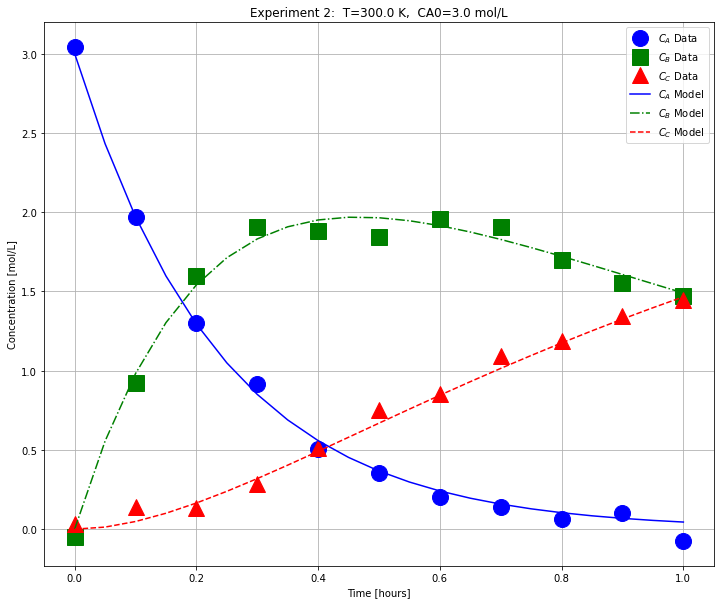

In [38]:
plot_data_and_model(theta_true, df)

## Perform Nonlinear Regression

### Solve Nonlinear Least Squares Problem

In [9]:
# nonlinear parameter estimation with full physics model
def regression_func(theta, data):
    '''
    Function to define regression function for least-squares fitting
    
    Note: This only uses CB measurements
    
    Arguments:
        theta: parameter vector
        data: Pandas data frame
    Returns:
        e: residual vector
    '''
    # determine number of entries in data frame
    n = len(data)

    # initialize matrix of residuals
    # rows: each row of Pandas data frame
    # columns: species CA, CB, CC
    e = np.zeros(n)

    # loop over experiments
    for i in data.exp.unique():

        # select the rows that correspond to the specific experiment number
        j = (data.exp == i)

        # determine experiment conditions
        CA0_ = float(data.CA0[j].mode())
        T_ = float(data.temp[j].mode())

        # determine experiment time
        t = data.time[j].to_numpy()

        CA, CB, CC = batch_rxn_model(theta,t,CA0_,T_)

        # Only use CB measurements
        e[j] = CB - data.CB[j]

    return e

Let's test our function.

In [10]:
e_test = regression_func(theta_true, df)
print(e_test)

[-0.04001078  0.00070513 -0.03010775  0.05715544 -0.00709748 -0.02573995
 -0.04657738  0.02541286 -0.03578653  0.03929134 -0.00518009  0.04862453
  0.06119177 -0.05714458 -0.07569756  0.06721667  0.12310389 -0.04184063
 -0.07882551  0.02083925  0.05518532  0.0221232 ]


Finally, we can compute the best fit estimate.

In [39]:
# Initial guess
theta0 = [85., 370., 7.5, 15]

# Bounds
bnds = ([50, 300, 5, 10,], [200, 400, 20, 50])

# Define function that includes data
my_func = lambda theta_ : regression_func(theta_, df)

# Perform nonlinear least squares
nl_results = optimize.least_squares(my_func, theta0, bounds=bnds, method='trf',verbose=2)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9432e-02                                    1.32e-01    
       1              2         2.8908e-02      5.24e-04       5.74e+00       2.19e-02    
       2              3         2.8773e-02      1.36e-04       2.09e+01       1.52e-02    
       3              4         2.8746e-02      2.71e-05       6.17e+00       1.50e-03    
       4              5         2.8733e-02      1.24e-05       9.53e+00       3.36e-03    
       5              6         2.8733e-02      3.64e-07       1.61e-01       3.66e-06    
       6              7         2.8733e-02      3.76e-10       5.10e-02       3.45e-07    
       7              8         2.8733e-02      1.24e-13       5.50e-04       1.57e-08    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.9432e-02, final cost 2.8733e-02, first-order optimality 1.57e-08.


In [44]:
theta_hat = nl_results.x
print("theta_hat =",theta_hat)

theta_hat = [ 81.74930715 332.10218587   7.38809902  14.686162  ]


### Visualize Results

First let's plot the data and model predictions.

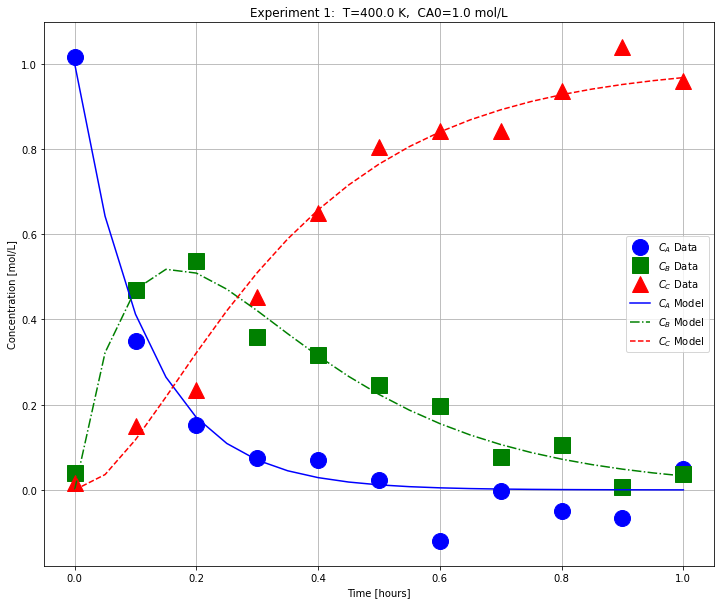

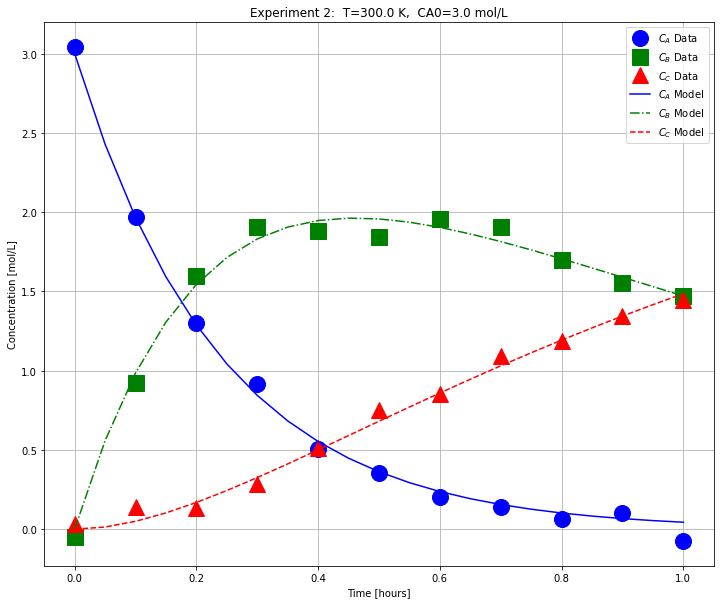

In [45]:
plot_data_and_model(theta_hat, df)

Next, let's look at the residuals. Recall, we only used $C_{B}$ in our regression formulation.

Text(0, 0.5, 'Count')

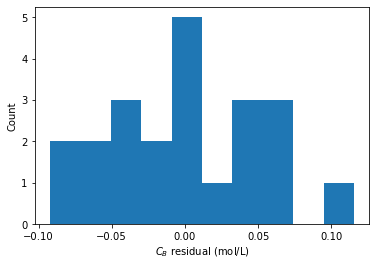

In [47]:
CB_residuals = regression_func(theta_hat, df)

plt.hist(CB_residuals)
plt.xlabel("$C_{B}$ residual (mol/L)")
plt.ylabel("Count")

### Estimate Uncertainty

First let's estimate the variance of the residuals.

In [55]:
sigre = (CB_residuals.T @ CB_residuals)/(len(CB_residuals) - len(theta_hat))

How does the standard deviation of the residuals compare to the standard deviation of the measurement noise?

In [57]:
print("Estimated Standard Deviation of Residuals =",np.sqrt(sigre),"mol/L")
print("Standard Deviation of Measurement Error in Synthetic Data =",noise_std_dev,"mol/L")

Estimated Standard Deviation of Residuals = 0.056502480414664484 mol/L
Standard Deviation of Measurement Error in Synthetic Data = 0.05 mol/L


Estimating the covariance matrix using a linearization approximation is easy!

In [58]:
Sigma_theta = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta)

Covariance matrix:
 [[ 2.94316274e+03 -9.43755492e+02  9.04923611e+01 -6.94814159e+00]
 [-9.43755492e+02  1.13821319e+04 -2.82264634e+01  8.74121495e+01]
 [ 9.04923611e+01 -2.82264634e+01  2.78919619e+00 -2.06299366e-01]
 [-6.94814159e+00  8.74121495e+01 -2.06299366e-01  6.75796229e-01]]


Recall the rows/colums are $A_1$, $A_2$, $E_1$, and $E_2$.

We can easily convert this to a correlation matrix.

In [53]:
corr_theta = Sigma_theta.copy()
for r in range(len(theta_hat)):
    for c in range(len(theta_hat)):
        corr_theta[r,c] = corr_theta[r,c]/np.sqrt(Sigma_theta[r,r])/np.sqrt(Sigma_theta[c,c])
        
print("Correlation matrix:\n",corr_theta)

Correlation matrix:
 [[ 1.         -0.16305741  0.99876945 -0.15579504]
 [-0.16305741  1.         -0.15841822  0.99667166]
 [ 0.99876945 -0.15841822  1.         -0.15026246]
 [-0.15579504  0.99667166 -0.15026246  1.        ]]


Discussion: Why are the pairs $A_1$, $E_2$ and $A_2$, $E_2$ highly correlated when measuring only $C_B$?

## Fisher Information Matrix

The first step of calculating the Fisher Information Matrix (FIM) is computing the sensitivity of all model outputs to each model parameter.

In [83]:
def calc_model_output(theta_,data):
    '''
    Assembles matrix out model outputs (columns) by experimental conditions (rows)
    
    Arguments:
        theta_: values of theta parameters, numpy array
        data: data frame of experimental conditions
    
    Returns:
        model_output: matrix
    '''
    
    # Allocate matrix of model outputs
    model_output = np.zeros((len(data),3))
    
    # Iterate over rows in pandas dataframe (each row is an experiment)
    for i,r in data.iterrows():
        # Evaluate model and store results
        model_output[i,:] = batch_rxn_model(theta_, r.time, r.CA0, r.temp)
        
    return model_output

# Test function at nominal values
print(calc_model_output(theta_hat,df))

[[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 4.12064066e-01  4.70224458e-01  1.17711475e-01]
 [ 1.69796795e-01  5.08546990e-01  3.21656215e-01]
 [ 6.99671577e-02  4.20281412e-01  5.09751431e-01]
 [ 2.88309515e-02  3.14251068e-01  6.56917981e-01]
 [ 1.18801991e-02  2.23927467e-01  7.64192334e-01]
 [ 4.89540316e-03  1.55491090e-01  8.39613507e-01]
 [ 2.01721973e-03  1.06393010e-01  8.91589771e-01]
 [ 8.31223766e-04  7.21716775e-02  9.26997099e-01]
 [ 3.42517445e-04  4.87050592e-02  9.50952423e-01]
 [ 1.41139131e-04  3.27658980e-02  9.67092963e-01]
 [ 3.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 1.96564447e+00  9.84961112e-01  4.93944212e-02]
 [ 1.28791939e+00  1.54366433e+00  1.68416285e-01]
 [ 8.43863874e-01  1.83070130e+00  3.25434827e-01]
 [ 5.52912119e-01  1.94669199e+00  5.00395894e-01]
 [ 3.62276216e-01  1.95695231e+00  6.80771478e-01]
 [ 2.37368746e-01  1.90372026e+00  8.58910992e-01]
 [ 1.55527521e-01  1.81416196e+00  1.03031052e+00]
 [ 1.01903937e-01  1.70561295e+

We'll use finite difference to estimate the sensitivities.

In [93]:
def calc_model_sensitivity(theta_,data):
    '''
    Estimate the model sensitivity matrix using forward finite difference
    
    Arguments:
        model_function: Python function that computes model outputs
        theta_: nominal value of theta
        exp_design_df: data frame containing experimental data
    '''
    
    # Evaluate model at nominal point
    nominal_output = calc_model_output(theta_,df)
    
    # Extract number of experiments and number of measured/output variables
    (n_exp, n_output) = nominal_output.shape
    
    # Set finite difference step size
    eps = 1E-5
    
    # Extract number of parameters
    n_param = len(theta_)
    
    # Create list to store model sensitity matrices
    model_sensitivity = []
    
    # Loop over number of outputs
    for i in range(n_output):
        
        # Allocate empty sensitivty matrix
        model_sensitivity.append(np.zeros((n_exp,n_param)))
    
    # Loop over parameters
    for p in range(n_param):
        output_forward = calc_model_output(theta_ + eps*np.ones(n_param), df)
        output_backward = calc_model_output(theta_ - eps*np.ones(n_param), df)
        
        sensitivity = (output_forward - output_backward) / (2*eps)
        
        # Loop over outputs
        for o in range(n_output):
            # Copy sensitivity results
            model_sensitivity[o][:,p] = sensitivity[:,o].copy()
    
    return model_sensitivity

model_sensitivity = calc_model_sensitivity(theta_hat, df)

print("CA sensitivity:\n",model_sensitivity[0])
print("CB sensitivity:\n",model_sensitivity[1])
print("CC sensitivity:\n",model_sensitivity[2])

CA sensitivity:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.05377773e-01 1.05377773e-01 1.05377773e-01 1.05377773e-01]
 [8.68447874e-02 8.68447874e-02 8.68447874e-02 8.68447874e-02]
 [5.36784243e-02 5.36784243e-02 5.36784243e-02 5.36784243e-02]
 [2.94919331e-02 2.94919331e-02 2.94919331e-02 2.94919331e-02]
 [1.51907073e-02 1.51907073e-02 1.51907073e-02 1.51907073e-02]
 [7.51145357e-03 7.51145357e-03 7.51145357e-03 7.51145357e-03]
 [3.61106678e-03 3.61106678e-03 3.61106678e-03 3.61106678e-03]
 [1.70056099e-03 1.70056099e-03 1.70056099e-03 1.70056099e-03]
 [7.88332584e-04 7.88332584e-04 7.88332584e-04 7.88332584e-04]
 [3.60937256e-04 3.60937256e-04 3.60937256e-04 3.60937256e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.23012131e-01 3.23012131e-01 3.23012131e-01 3.23012131e-01]
 [4.23284672e-01 4.23284672e-01 4.23284672e-01 4.23284672e-01]
 [4.16013587e-01 4.16013587e-01 4.16013587e-01 4.16013587e-01]
 [3.63437691e-01 3.63437691e-01 3.6343

We are now ready to compute the FIM for each of the three measurements:

$$
M_{i} = (\sigma^{-2}_{i}) \mathbf{Q}_{i}^{T} \mathbf{Q}_{i} \quad \forall i \in \{C_A, C_B, C_C \}
$$

In [ ]:
# Allocate list of FIM
FIM = []
for i in range(0,3):
    FIM.append( 1/noise_std_dev**2 * model_sensitivity[i].T @ model_sensitivity[i])

print("FIM for CA 

## What is the next best experiment?

## Can we calibrate the model with just one experiment?

## Take Away Messages

In [ ]:
def generate_exp(t_set, CA0, T):  
    """Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    """
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [ ]:
# empty prior
prior_pass = np.zeros((4,4))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

## Method: Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [ ]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


result = doe_object.compute_FIM(exp1, mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                scale_nominal_param_value=True,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


In [ ]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degree of freedom and solves again. In this way the optimization problem can be well initialized. 

In [ ]:
exp1 = generate_exp(t_control, 3, [500, 300, 300, 300, 300, 300, 300, 300, 300])

# add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])



In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=np.linalg.cholesky(prior))

In [ ]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(pyo.value(optimize_result.model.T[i]))
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [ ]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
# add prior information
prior_all = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

print(np.shape(prior_all))

prior_pass=np.asarray(prior_all)
print(np.shape(prior_pass))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:
# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T are for different controlling time subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )